In [2]:
import torch
from torch import nn
from PIL import Image
import numpy as np


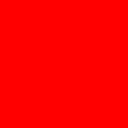

In [3]:
img = Image.new('RGB', (128, 128), color = 'red')
img.show()

In [4]:
img_array = np.array(img)
img_array = img_array/255
img_array = img_array.transpose(2, 0, 1).astype(np.float32)

In [6]:
img_tensor = torch.from_numpy(img_array)
img_tensor = img_tensor.unsqueeze(0)
print(img_tensor.shape)

torch.Size([1, 3, 128, 128])


In [7]:
def image_to_tensor(image: Image) -> torch.Tensor:
    img_array = np.array(image)
    img_array = img_array/255
    img_array = img_array.transpose(2, 0, 1).astype(np.float32)
    img_tensor = torch.from_numpy(img_array)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

def tensor_to_image(tensor: torch.Tensor) -> Image:
    img_array = tensor.squeeze(0).numpy()
    img_array = img_array.transpose(1, 2, 0)
    img_array = img_array*255
    img_array = img_array.astype(np.uint8)
    image = Image.fromarray(img_array)
    return image

In [53]:
color = tuple[int, int, int]
def create_empty_image(resolution: int, color: color=(0,0,0)) -> Image:
    return Image.new('RGB', (resolution, resolution), color = color)

In [54]:
init_tensor = image_to_tensor(create_empty_image(128, color=(255, 0, 0)))
target_tensor = image_to_tensor(create_empty_image(128, color=(0, 255, 0)))

In [9]:
conv = torch.nn.Conv2d(3, 3, 3, padding=1)
lr = 0.01
min_steps = 100

for step in range(min_steps):
    y = conv(init_tensor)
    loss = (y - target_tensor).norm()
    loss.backward()

    with torch.no_grad():
        init_tensor -= lr*init_tensor.grad
        init_tensor.grad.zero_()

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [10]:
class Linear(nn.Module):
    def __init__(self, in_features: int=1, out_features: int=1) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.randn(out_features))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.weight.t() + self.bias

linear = Linear(in_features=3, out_features=3)
x = torch.randn(1, 3)
target_tensor = torch.randn(1, 3)
y = linear(x)
loss = ((y - target_tensor)**2).mean()
loss.backward()

In [11]:
linear.weight.grad

tensor([[ 2.2304e+00, -5.2909e-01, -6.1829e+00],
        [-3.7378e+00,  8.8666e-01,  1.0361e+01],
        [-2.3452e-02,  5.5632e-03,  6.5010e-02]])

In [12]:
class resblock(nn.Module):
    def __init__(self, in_channels: int=1, out_channels: int=1) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.silu = nn.SiLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv1(x)
        y = self.silu(x)
        y = self.conv2(x)
        return y+x

In [13]:
block = resblock(3, 3)

lr = 1e-5
min_steps = 10000
for step in range(min_steps):
    y = block(init_tensor)
    loss = (y - target_tensor).norm()
    loss.backward()

    with torch.no_grad():
        print(f'step: {step}, loss: {loss.item()}')
        for param in block.parameters():
            assert param.grad is not None
            param -= lr*param.grad

result = conv(init_tensor)
tensor_to_image(result)

RuntimeError: The size of tensor a (128) must match the size of tensor b (3) at non-singleton dimension 3

In [64]:
class Encoder(nn.Module):
    def __init__(self, input_channels: int = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.silu = nn.SiLU()
        self.maxpool = nn.MaxPool2d(2)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv1(x)
        y = self.silu(y)
        y = self.maxpool(y)
        y = self.conv2(y)
        y = self.silu(y)
        y = self.maxpool(y)
        y = self.conv3(y)
        y = self.silu(y)
        y = self.maxpool(y)
        y = self.conv4(y)
        y = self.silu(y)
        y = self.maxpool(y)
        return y

class Decoder(nn.Module):
    def __init__(self, output_channels: int = 3):
        super().__init__()
        self.conv1 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, output_channels, 3, padding=1)
        self.silu = nn.SiLU()
        self.upsample = nn.Upsample(scale_factor=2)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv1(x)
        y = self.silu(y)
        y = self.upsample(y)
        y = self.conv2(y)
        y = self.silu(y)
        y = self.upsample(y)
        y = self.conv3(y)
        y = self.silu(y)
        y = self.upsample(y)
        y = self.conv4(y)
        y = self.silu(y)
        y = self.upsample(y)
        return y
    
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(self.encoder(x))

In [74]:
autoencoder = AutoEncoder()
lr = 1e-4
num_steps = 1000
optimizer = torch.optim.SGD(autoencoder.parameters() , lr=lr)
for step in range(num_steps):
    y = autoencoder(init_tensor)
    loss = (y-init_tensor).norm()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"step {step} : loss {loss.item()}")

step 0 : loss 128.6528778076172
step 1 : loss 128.21038818359375
step 2 : loss 127.76188659667969
step 3 : loss 127.30679321289062
step 4 : loss 126.84478759765625
step 5 : loss 126.37632751464844
step 6 : loss 125.90122985839844
step 7 : loss 125.42005157470703
step 8 : loss 124.93059539794922
step 9 : loss 124.43502807617188
step 10 : loss 123.93255615234375
step 11 : loss 123.42205810546875
step 12 : loss 122.9047622680664
step 13 : loss 122.37893676757812
step 14 : loss 121.83979034423828
step 15 : loss 121.29861450195312
step 16 : loss 120.74919891357422
step 17 : loss 120.19261932373047
step 18 : loss 119.62739562988281
step 19 : loss 119.05462646484375
step 20 : loss 118.47195434570312
step 21 : loss 117.88108825683594
step 22 : loss 117.28244018554688
step 23 : loss 116.67326354980469
step 24 : loss 116.05571746826172
step 25 : loss 115.4289321899414
step 26 : loss 114.79264831542969
step 27 : loss 114.14610290527344
step 28 : loss 113.49009704589844
step 29 : loss 112.82311248

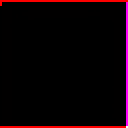

In [75]:
tensor_to_image(autoencoder(init_tensor).data)

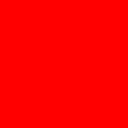

In [76]:
tensor_to_image(init_tensor.data)

In [9]:
from PIL import Image, ImageDraw
import random

def generate_image(size, num_images):
    for i in range(num_images):
        # Create a new image with a random background color
        img = Image.new("RGB", size, color=(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

        # Get a drawing context
        draw = ImageDraw.Draw(img)

        # Choose a random shape (circle, square, or triangle)
        shape = random.choice(["circle", "square", "triangle"])

        # Choose a random position
        position = (random.randint(20, size[0]-20), random.randint(20, size[1]-20))

        # Choose a random color for the shape
        shape_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        # Draw the shape on the image
        if shape == "circle":
            draw.ellipse([position[0]-20, position[1]-20, position[0]+20, position[1]+20], fill=shape_color)
        elif shape == "square":
            draw.rectangle([position[0]-20, position[1]-20, position[0]+20, position[1]+20], fill=shape_color)
        elif shape == "triangle":
            draw.polygon([(position[0], position[1]-20), (position[0]-20, position[1]+20), (position[0]+20, position[1]+20)], fill=shape_color)

        # Show the image
        img.show()


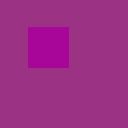

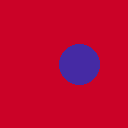

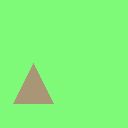

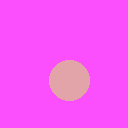

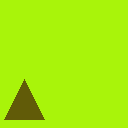

In [77]:
image_size = (128, 128)
num_images = 5  # Change this to the number of images you want to generate

generate_image(image_size, num_images)